In [5]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup as bs
import pandas as pd
import time
import re

In [6]:
# This section is for Windows computer
chromeOptions = Options()
chromeOptions.headless = False
driver = webdriver.Chrome(ChromeDriverManager().install(), options=chromeOptions)



====== WebDriver manager ======
Current google-chrome version is 112.0.5615
Get LATEST chromedriver version for 112.0.5615 google-chrome
Trying to download new driver from https://chromedriver.storage.googleapis.com/112.0.5615.49/chromedriver_win32.zip
Driver has been saved in cache [C:\Users\JeanP\.wdm\drivers\chromedriver\win32\112.0.5615.49]
c:\Users\JeanP\anaconda3\envs\PythonData_20230404\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  after removing the cwd from sys.path.


In [3]:
# Comment out this section, used by pgarias on macos
# s = Service('/Users/pgarias/.wdm/drivers/chromedriver/mac64/106.0.5249/chromedriver')
# chromeOptions = Options()
# chromeOptions.headless = False
# driver = webdriver.Chrome(executable_path=s.path, options=chromeOptions)

In [7]:
# Create the url pattern for search in home depot web page
base_url = "https://www.homedepot.com/s/"
search_term = "floor title"

url = f"{base_url}{search_term}"
print(url)

https://www.homedepot.com/s/floor title


In [10]:
# Create an empty list to contain each page's products
df_list = []

# Navigate to the url and execute script to scroll down. This is needed when you need to make sure that the "Next" button and
# all products have been sucessfully loaded to the page.
driver.get(url)
driver.execute_script("window.scrollTo(0, document.body.scrollHeight/1.5);")

# Get the html page source and pass it to Beautiful Soup
html = driver.page_source
soup = bs(html, 'html.parser')

try:

    # Get the total number of products that appears in the search. This is used to get to the end of all the pages. 'page_count' 
    # is the number of products up to and including the current page. 'total_count' is the total number of products in the 
    # search query.
    pagination_results = soup.find_all("span",class_="results-pagination__counts--number")
    page_count = int(pagination_results[0].text.split("-")[1].strip())
    total_count = int(pagination_results[1].text.strip())

    cont=True

    while(cont):
        # This ensures that "Next" button and all products have loaded
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight/1.5);")
        time.sleep(5)
        # Get the html page source and pass it to Beautiful Soup
        html = driver.page_source
        soup = bs(html, 'html.parser')

        # This part checks the page count in each page of the results
        pagination_results = soup.find_all("span",class_="results-pagination__counts--number")
        page_count = int(pagination_results[0].text.split("-")[1].strip())

    
        if page_count!=total_count:
            #Extract each product pod in the search page
            company_detail = soup.find_all("div", class_="browse-search__pod col__12-12 col__6-12--xs col__4-12--sm col__3-12--md col__3-12--lg")
        
            #  Print some details of the page
            print(f'''
            Count up to current page: {page_count}
            Count of products on this page: {len(company_detail)}
            Total count: {total_count}
            ''')
            # Retail price: in each pod, find the div element w/ "price" class, and extract a list of all the span elements
            # Then, extract the 2nd and 3rd (or 1 and 2 index) spans to compose the price using join and float
            span_price = [spanList.find("div",class_="price").find_all("span") for spanList in company_detail]
            retail_price = [float(".".join([each[1].text, each[2].text])) if len(each) == 3 else float(".".join([each[0].text, each[1].text[:-1]])) for each in span_price]

            #Company list: In each pod, extract the text from the span w/ class=product-pod__title__brand--bold if it exists. If it does not exist, return "None"
            company_list = [comp.find("p",class_="product-header__title__brand--bold--4y7oa").text if comp.find("p",class_="product-header__title__brand--bold--4y7oa") else None for comp in company_detail]
            # Product list: extract the text from the span w/ class=product-pod__title__product 
            product_list = [comp.find("span",class_="product-header__title-product--4y7oa").text if comp.find("span",class_="product-header__title-product--4y7oa") is not None else "" for comp in company_detail]
            # Reviewers count: extract and clean the number from the span w/ class=ratings__count--6r7g3 if it exists. If it does not exist, return "None"
            reviewers_count = [int(comp.find("span",class_="ratings__count--6r7g3").text.strip("(").strip(")")) if comp.find("span",class_="ratings__count--6r7g3") else None for comp in company_detail]
            # Rating list
            rating_list = [comp.find("span",class_="stars--c43xm")['style'].split(":")[1].strip().strip(";") if comp.find("span",class_="stars--c43xm") else None for comp in company_detail]
            #Badge list
            badge_list = [item.find("span",class_="badge-container--dimm8 u__bold product-badge--dvs1t product-badge--large--dvs1t")['title'] if item.find("span",class_="badge-container--dimm8 u__bold product-badge--dvs1t product-badge--large--dvs1t") else None for item in company_detail ]

            # Create a data frame from the above lists, add column list, and append this data frame to the list of data frames. 
            df_list.append(pd.DataFrame(list(zip(company_list, product_list, retail_price, reviewers_count, rating_list, badge_list)), 
                    columns = ['Company','Description','Price','Num. of Reviews', 'Rating','Badge']))
        
            # Find element that has the aria-label attribute set to "Next", then, after a few seconds, run the .click method
            time.sleep(5)
            click_button = driver.find_element(by=By.CSS_SELECTOR, value='a[aria-label=Next]')
            time.sleep(5)
            click_button.click()
        else:
            company_detail = soup.find_all("div", class_="browse-search__pod col__12-12 col__6-12--xs col__4-12--sm col__3-12--md col__3-12--lg")
            print(f'''
            Count up to current page: {page_count}
            Count of products on this page: {len(company_detail)}
            Total count: {total_count}
            ''')
            # Retail price
            span_price = [spanList.find("div",class_="price").find_all("span") for spanList in company_detail]
            retail_price = [float(".".join([each[1].text,each[2].text])) for each in span_price]
            #Company list
            company_list = [comp.find("p",class_="product-header__title__brand--bold--4y7oa").text if comp.find("p",class_="product-header__title__brand--bold--4y7oa") else None for comp in company_detail]
            # Product list
            product_list = [comp.find("span",class_="product-header__title-product--4y7oa").text if comp.find("span",class_="product-header__title-product--4y7oa") is not None else "" for comp in company_detail]
            # Reviewers count
            reviewers_count = [int(comp.find("span",class_="ratings__count--6r7g3").text.strip("(").strip(")")) if comp.find("span",class_="ratings__count--6r7g3") else None for comp in company_detail]
            # Rating list
            rating_list = [comp.find("span",class_="stars--c43xm")['style'].split(":")[1].strip().strip(";") if comp.find("span",class_="stars--c43xm") else None for comp in company_detail]
            #Badge list
            badge_list = [item.find("span",class_="badge-container--dimm8 u__bold product-badge--dvs1t product-badge--large--dvs1t")['title'] if item.find("span",class_="badge-container--dimm8 u__bold product-badge--dvs1t product-badge--large--dvs1t") else None for item in company_detail ]

            df_list.append(pd.DataFrame(list(zip(company_list, product_list, retail_price, reviewers_count, rating_list, badge_list)), 
                    columns = ['Company','Description','Price','Num. of Reviews', 'Rating','Badge']))

            print("End of pages")
            cont=False

except KeyboardInterrupt:
    print("Script End")





        Count up to current page: 24
        Count of products on this page: 24
        Total count: 761
        

        Count up to current page: 48
        Count of products on this page: 24
        Total count: 761
        

        Count up to current page: 72
        Count of products on this page: 24
        Total count: 761
        

        Count up to current page: 96
        Count of products on this page: 24
        Total count: 761
        

        Count up to current page: 120
        Count of products on this page: 24
        Total count: 761
        

        Count up to current page: 144
        Count of products on this page: 24
        Total count: 761
        

        Count up to current page: 168
        Count of products on this page: 24
        Total count: 761
        

        Count up to current page: 192
        Count of products on this page: 24
        Total count: 761
        

        Count up to current page: 216
        Count of products on this pag

KeyboardInterrupt: 

In [12]:
# Create a data frame that concatenates all the data frames in the list, reset the index.
df = pd.concat(df_list).reset_index(drop=True)
pd.set_option("max_rows", None)
pd.set_option("max_colwidth", None)
df.to_csv('HomeDepot_Data', index=False)

In [68]:
#Read the CSV file we created
dataframe = pd.read_csv('HomeDepot_Data')

#Filter Out Vinyl Floor as thats not our target
df_filtered = dataframe[~dataframe['Description'].str.contains('Vinyl')]
df_filtered

# define regular expression pattern to extract size in inches
pattern = r'(\d+(\.\d+)?\s*in\.?\s*x\s*\d+(\.\d+)?\s*in\.?)'

# create a new column to store extracted sizes in inches
df_filtered['Size (in)'] = df_filtered['Description'].str.extract(pattern)[0]

# Converting columns to proper values
df_filtered['Rating'] = df_filtered['Rating'].str.rstrip('%').astype('float64')

main_data = df_filtered

# print the resulting dataframe
print(main_data.dtypes)
main_data.head()


Company             object
Description         object
Price              float64
Num. of Reviews    float64
Rating             float64
Badge               object
Size (in)           object
dtype: object


c:\Users\JeanP\anaconda3\envs\PythonData_20230404\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
c:\Users\JeanP\anaconda3\envs\PythonData_20230404\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,Company,Description,Price,Num. of Reviews,Rating,Badge,Size (in)
0,TrafficMaster,Portland Stone Beige 18 in. x 18 in. Glazed Ceramic Floor and Wall Tile (17.44 sq. ft. / case),1.09,697.0,84.418,Exclusive,18 in. x 18 in.
1,Marazzi,Montagna Dapple Gray 6 in. x 24 in. Porcelain Floor and Wall Tile (14.53 sq. ft. / case),1.97,1435.0,93.686,NaN,6 in. x 24 in.
2,TrafficMaster,Glenwood Fog 7 in. x 20 in. Ceramic Floor and Wall Tile (10.89 sq. ft. / case),1.31,660.0,93.242,Exclusive,7 in. x 20 in.
3,Daltile,Cascade Ridge 24 in. x 12 in. Slate Ceramic Floor and Wall Tile (15.04 sq. ft. / case),1.75,390.0,90.512,Exclusive,24 in. x 12 in.
5,Marazzi,Montagna Rustic Bay 6 in. x 24 in. Glazed Porcelain Floor and Wall Tile (14.53 sq. ft. / case),1.97,1437.0,93.696,NaN,6 in. x 24 in.


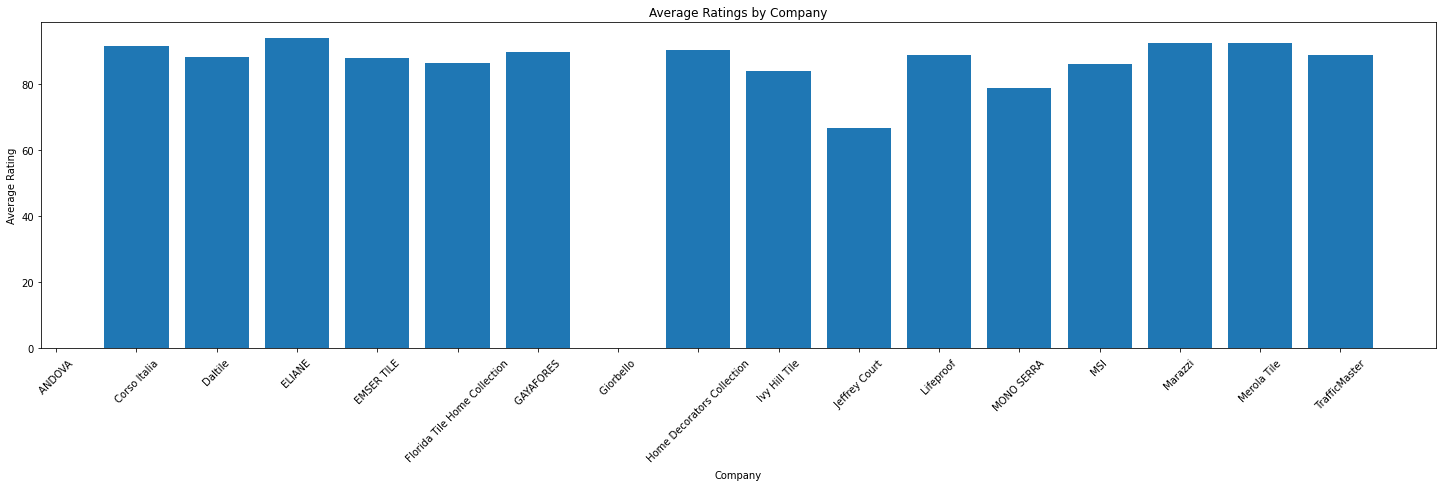

In [69]:
import matplotlib.pyplot as plt

# assuming the data is stored in a DataFrame called df
ratings_by_company = main_data.groupby('Company')['Rating'].mean()

# create a bar graph
plt.figure(figsize=(25, 6))  # set figure size
plt.bar(ratings_by_company.index, ratings_by_company.values)
plt.title('Average Ratings by Company')
plt.xlabel('Company')
plt.ylabel('Average Rating')

# rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# display value labels above each bar
#for i, v in enumerate(ratings_by_company.values):
    #plt.text(i, v+0.01, str(round(v, 2)), ha='center')


plt.show()

KeyError: 'Size (in)'